## <b> KNN Notebook </b>

### <b> Goals </b>

The goals of our project are focused around implementing ways to improve the way the KNN algorithm classifies binary data when consuming datasets that present heavy class imbalances.

### <b> KNN base algorithm </b>

This is the base algorithm along with its classifier and regressor.

In [129]:
from collections import Counter
import numpy as np
from scipy.spatial.distance import euclidean
from base import BaseEstimator


class KNNBase(BaseEstimator):
    def __init__(self, k=5, distance_func=euclidean):
        self.k = k
        self.distance_func = distance_func

    def aggregate(self, neighbors_targets):
        raise NotImplementedError()

    def _predict(self, X=None):
        predictions = [self._predict_x(x) for x in X]
        return np.array(predictions)

    def _predict_x(self, x):
        distances = [self.distance_func(x, example) for example in self.X]
        neighbors = sorted(zip(distances, self.y), key=lambda x: x[0])
        neighbors_targets = [target for (_, target) in neighbors[:self.k]]
        return self.aggregate(neighbors_targets)

    def get_params(self, deep=True):
        return {'k': self.k, 'distance_func': self.distance_func}

    def set_params(self, **params):
        if 'k' in params:
            self.k = params['k']
        if 'distance_func' in params:
            self.distance_func = params['distance_func']


from collections import Counter
import numpy as np
from scipy.spatial.distance import euclidean
from base import BaseEstimator

class KNNClassifier(KNNBase):
    def aggregate(self, neighbors_targets):
        most_common_label = Counter(neighbors_targets).most_common(1)[0][0]
        return most_common_label

    def predict_proba(self, X=None):
        probabilities = []
        n_classes = len(np.unique(self.y))  # Number of unique class labels in training data
        for x in X:
            distances = [self.distance_func(x, example) for example in self.X]
            neighbors = sorted(zip(distances, self.y), key=lambda x: x[0])
            neighbors_targets = [target for (_, target) in neighbors[:self.k]]
            class_counts = Counter(neighbors_targets)
            prob = np.zeros(n_classes)
            for class_label, count in class_counts.items():
                prob[class_label] = count / self.k
            probabilities.append(prob)
        return np.array(probabilities)


### <b> Dataset Exploratory Data Analysis </b>

In this section of the notebook our aim is to better understand our dataset.
As previously mentioned our main focus is to tackle KNN problems related to Binary Class Imbalances, therefore we'll start by checking if the datasets we'll be using actually do present those problems.

In [130]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml #Fetch Method for OpenML datasets

##### <b> Functions to extract data and observe binary class imbalances </b>



In [131]:
#Function to fetch datasets and transform them into dataframe
def dataset_fetcher(dataset_id):
    #Fetch OpenML dataset
    dataset = fetch_openml(data_id=dataset_id, version='active', as_frame=True)
    
    dataset_name = dataset.details['name']

    #Convert dataset to pandas dataframe
    df = dataset.frame

    #Change last column name to "class" in all dataframes
    last_column_name = df.columns[-1] 
    df = df.rename(columns={last_column_name: 'class'})


    return df, dataset_name


#Function to show number of entries for each label/class
def item_number_per_class(dataframe, ds_name):

    #Select class column
    label_column = dataframe.iloc[:,-1]
    
    # Count the occurrences of each value
    occurrences = label_column.value_counts()

    return occurrences, ds_name

#Function to plot the data
def plot_number_of_entries_per_class(num_occurrences, dsname):

    
    plt.figure(figsize=(3, 2))

    # Plotting the occurrences as a bar chart
    num_occurrences.plot(kind='bar', rot=0)

    # Adding labels and title
    plt.xlabel('Item')
    plt.ylabel('Count')
    plt.title(f'Occurrences of Each Item in {dsname}')

    # Display the plot
    plt.show()

#Pipline for EDA
def data_generation_pipeline(datasets_id):

    '''
    Function will return a list of dataframes that will then be used to benchmark the algorithm
    '''
    dataframes = []
    for id in datasets_id:
        dataframe, dsname = dataset_fetcher(id)
        dataframes.append(dataframe)
        occurrences, dsname = item_number_per_class(dataframe, dsname)
        plot_number_of_entries_per_class(occurrences, dsname)

    return dataframes
    
    

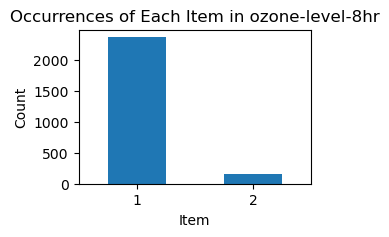

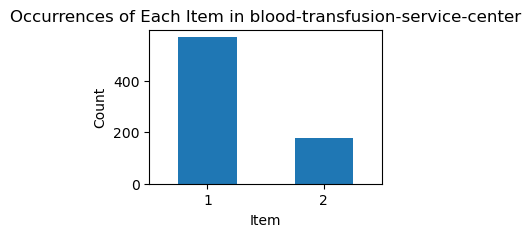

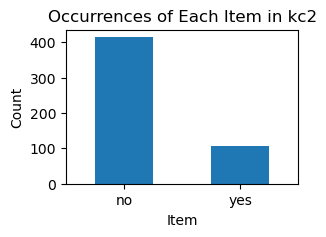

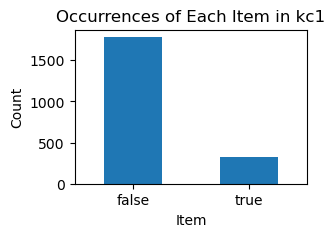

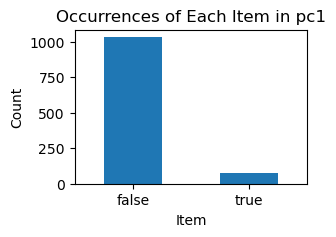

In [237]:
dataset_id_list = [1487, 1464, 1063, 1067, 1068]
dataframes = data_generation_pipeline(dataset_id_list)

As displayed above in the graphs, we can clearly see that every single one of the datasets that we are using has severe class imbalances.

#### <b> Convert non-numeric values to numeric values </b>

Since our Classifier only works with numerical values, we need to replace all of the non-numerical entries in our dataframe.
We also want to ensure that in each column, the identity of the unique data points is preserved, meaning that within the same column previously non-numerical values that are the same will also have the same numerical representation.

On top of that, we'll also implement a way to replace non-available values (NaN) by inserting the mean of the column by NaN in a given entry.

In [133]:
from sklearn.preprocessing import LabelEncoder
def encode_non_numerical_and_nan(df):
    df_encoded = df.copy()
    
    for column in df_encoded.columns:
        if pd.api.types.is_object_dtype(df_encoded[column]) or df_encoded[column].apply(lambda x: isinstance(x, str)).any():
            le = LabelEncoder()
            df_encoded[column] = le.fit_transform(df_encoded[column])

    # Replace NaN values with the mean of the column
    for column in df_encoded.columns:
        if df_encoded[column].isnull().any():
            mean_value = df_encoded[column].mean()
            df_encoded[column].fillna(mean_value, inplace=True)
    
    return df_encoded

In [238]:
dataframerinos = []

for id in dataset_id_list:
    dfx = dataset_fetcher(id)[0]
    dfx_encoded = encode_non_numerical_and_nan(dfx)
    dfx_encoded.tail()
    dataframerinos.append(dfx_encoded)


### <b> Performance of the base KNN Algorithm </b>

Now, we'll benchmark the base implementation of the KNN algorithm, using some well defined metrics, to see how it performs when we feed it the previously chosen datasets.

In [258]:
#Imports
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from collections import Counter
from scipy.spatial.distance import euclidean
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import numpy as np
from scipy.spatial.distance import euclidean
from base import BaseEstimator



In [259]:
def knnBasePerformanceMetrics(dataframe_set, k, n_splits, random_state=42):
    # Separate features from class labels
    X = dataframe_set.drop(columns=['class']).values  # Features as numpy array
    y = dataframe_set['class'].values  # Labels as numpy array

    # Instantiate a classifier
    knn = KNNClassifier(k=k)

    # Define the k-fold cross-validator
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Initialize lists to store metric scores
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []

    fpr_list = []  # List to store FPR values for each fold
    tpr_list = []  # List to store TPR values for each fold
    thresholds_list = []  # List to store thresholds for each fold


    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Fit the model
        knn.fit(X_train, y_train)

        # Make predictions
        y_pred = knn.predict(X_test)

        # Calculate evaluation metrics
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        
        # Calculate AUC-ROC
        y_prob = knn.predict_proba(X_test)[:, 1]
        roc_auc_scores.append(roc_auc_score(y_test, y_prob))

        # Compute ROC curve values
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        thresholds_list.append(thresholds)

    # Calculate mean scores
    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_roc_auc = np.mean(roc_auc_scores)

    metric_scores_lists_og = [accuracy_scores, precision_scores, recall_scores, f1_scores, roc_auc_scores]
    roc_curve_data = {'fpr': fpr_list, 'tpr': tpr_list, 'thresholds': thresholds_list}

    return mean_accuracy, mean_precision, mean_recall, mean_f1, roc_auc_scores, metric_scores_lists_og, roc_curve_data




In [200]:
# Example usage:
#for df in dataframerinos:
mean_accuracy, mean_precision, mean_recall, mean_f1, mean_roc_auc, metric_scores_lists_og = knnBasePerformanceMetrics(dataframerinos[0], k=5, n_splits=5)
print(f"Mean Accuracy: {mean_accuracy}, Mean Precision: {mean_precision}, Mean Recall: {mean_recall}, Mean F1 Score: {mean_f1}, Mean ROC-AUC: { mean_roc_auc}, Metrics Scores Lists: {metric_scores_lists_og}")

Mean Accuracy: 0.6540000000000001, Mean Precision: 0.7139178197964217, Mean Recall: 0.8442353867059431, Mean F1 Score: 0.7732406005391016, Mean ROC-AUC: 0.5709251306115284, Metrics Scores Lists: [[0.685, 0.66, 0.62, 0.66, 0.645], [0.7321428571428571, 0.7134502923976608, 0.6770186335403726, 0.7452229299363057, 0.7017543859649122], [0.8723404255319149, 0.8652482269503546, 0.8195488721804511, 0.8068965517241379, 0.8571428571428571], [0.7961165048543689, 0.782051282051282, 0.7414965986394558, 0.7748344370860927, 0.7717041800643086], [0.567255679769203, 0.521937732900589, 0.579957356076759, 0.5529153605015674, 0.6325595238095238]]


### <b> KNN modified algorithm </b>

First, we need to implement techniques such as oversampling of minority class instances or undersampling of majority class instances.

In [210]:
#KNN Distance + Class Weighting
class KNNBaseOp(BaseEstimator):
    def __init__(self, k, distance_func=euclidean):
        self.k = k
        self.distance_func = distance_func

    def aggregate(self, neighbors_targets, neighbor_distances):
        raise NotImplementedError()

    def _predict(self, X=None):
        predictions = [self._predict_x(x) for x in X]
        return np.array(predictions)

    def _predict_x(self, x):
        distances = [self.distance_func(x, example) for example in self.X]
        neighbors = sorted(zip(distances, self.y), key=lambda x: x[0])
        neighbor_distances = [d for d, _ in neighbors[:self.k]]
        neighbors_targets = [target for _, target in neighbors[:self.k]]
        return self.aggregate(neighbors_targets, neighbor_distances)

    def get_params(self, deep=True):
        return {'k': self.k, 'distance_func': self.distance_func}

    def set_params(self, **params):
        if 'k' in params:
            self.k = params['k']
        if 'distance_func' in params:
            self.distance_func = params['distance_func']

class KNNClassifierOptimized(KNNBaseOp):
    def __init__(self, k, distance_func=euclidean, class_weights=None):
        super().__init__(k=k, distance_func=distance_func)
        self.class_weights = class_weights

    def aggregate(self, neighbors_targets, neighbor_distances):
        class_weights = self._calculate_class_weights(neighbors_targets)
        weighted_votes = Counter()

        for i, target in enumerate(neighbors_targets):
            # Add a small epsilon value to avoid division by zero
            weight = class_weights[i] if neighbor_distances[i] > 0 else 0
            weighted_votes[target] += weight * (1 / (neighbor_distances[i] + np.finfo(float).eps))

        most_common_label = weighted_votes.most_common(1)[0][0]
        return most_common_label

    def _calculate_class_weights(self, neighbors_targets):
        if self.class_weights is None:
            return np.ones(len(neighbors_targets))  # Default equal weights
        else:
            return np.array([self.class_weights[target] for target in neighbors_targets])

    def predict_proba(self, X=None):
        probabilities = []
        for x in X:
            distances = [self.distance_func(x, example) for example in self.X]
            neighbors = sorted(zip(distances, self.y), key=lambda x: x[0])
            neighbor_distances = [d for d, _ in neighbors[:self.k]]
            neighbors_targets = [target for _, target in neighbors[:self.k]]
            class_weights = self._calculate_class_weights(neighbors_targets)
            prob = np.zeros(len(np.unique(self.y)))
            for i, class_label in enumerate(np.unique(self.y)):
                class_indices = [j for j, target in enumerate(neighbors_targets) if target == class_label]
                prob[i] = np.sum(class_weights[class_indices]) / np.sum(class_weights)
            probabilities.append(prob)
        return np.array(probabilities)
    


With all the new features implemented, we can now make the test

In [257]:
from sklearn.metrics import roc_curve, roc_auc_score

def knnPerformanceMetrics(dataframe_set, k, n_splits, random_state=42):
    X = dataframe_set.drop(columns=['class']).values
    y = dataframe_set['class'].values

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y), class_weights)}

    knn = KNNClassifierOptimized(k=k, class_weights=class_weights_dict)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []

    fpr_list = []  # List to store FPR values for each fold
    tpr_list = []  # List to store TPR values for each fold
    thresholds_list = []  # List to store thresholds for each fold

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))

        y_prob = knn.predict_proba(X_test)[:, 1]
        roc_auc_scores.append(roc_auc_score(y_test, y_prob))

        # Compute ROC curve values
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        thresholds_list.append(thresholds)

    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_roc_auc = np.mean(roc_auc_scores)

    metric_scores_lists = [accuracy_scores, precision_scores, recall_scores, f1_scores, roc_auc_scores]
    roc_curve_data = {'fpr': fpr_list, 'tpr': tpr_list, 'thresholds': thresholds_list}
    
    return mean_accuracy, mean_precision, mean_recall, mean_f1, roc_auc_scores, metric_scores_lists, roc_curve_data


# Evaluate on your datasets
#for df in dataframerinos:
#mean_accuracy, mean_precision, mean_recall, mean_f1,  roc_auc_scores, metrics_scores_lists_opt, roc_curve_data = knnPerformanceMetrics(dataframerinos[0], k=5, n_splits=5)
#print(f"Mean Accuracy: {mean_accuracy}, Mean Precision: {mean_precision}, Mean Recall: {mean_recall}, Mean F1 Score: {mean_f1}, Mean ROC-AUC: { mean_roc_auc}, Metrics Scores Lists: {metrics_scores_lists_opt}, ROC Curve data: {roc_curve_data}")





In [202]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

# Assuming KNNClassifierOptimized and knnPerformanceMetrics are defined as provided

def knnGridSearch(dataframe_set, k_values, n_splits_values, random_state=42):
    best_params = {'k': None, 'n_splits': None}
    best_score = 0

    X = dataframe_set.drop(columns=['class']).values
    y = dataframe_set['class'].values

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
    class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y), class_weights)}

    for k in k_values:
        for n_splits in n_splits_values:
            knn = KNNClassifierOptimized(k=k, class_weights=class_weights_dict)
            kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

            accuracy_scores = []
            precision_scores = []
            recall_scores = []
            f1_scores = []
            roc_auc_scores = []

            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                knn.fit(X_train, y_train)
                y_pred = knn.predict(X_test)

                accuracy_scores.append(accuracy_score(y_test, y_pred))
                precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
                recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
                f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

                if len(np.unique(y)) == 2:  # Binary classification case
                    y_prob = knn.predict_proba(X_test)[:, 1]
                    roc_auc_scores.append(roc_auc_score(y_test, y_prob))

            mean_accuracy = np.mean(accuracy_scores)
            mean_precision = np.mean(precision_scores)
            mean_recall = np.mean(recall_scores)
            mean_f1 = np.mean(f1_scores)
            mean_roc_auc = np.mean(roc_auc_scores) if roc_auc_scores else 0

            # Use mean F1 score as the primary metric for best score
            if mean_recall > best_score:
                best_score = mean_recall
                best_params['k'] = k
                best_params['n_splits'] = n_splits

    return best_params, best_score
'''

for df in dataframerinos:
    best_params, best_score = knnGridSearch(df, k_values, n_splits_values)
    print(f"Best Params: {best_params}, Best Score: {best_score}")
'''

'\n\nfor df in dataframerinos:\n    best_params, best_score = knnGridSearch(df, k_values, n_splits_values)\n    print(f"Best Params: {best_params}, Best Score: {best_score}")\n'

### <b> Algorithm Performance Comparison </b>

In [252]:
def plot_metrics_graphs(original_metric, optimized_metric, metric_name):
    
     
    x = list(range(1, len(original_metric) + 1))

    # Create the plot
    plt.plot(x, original_metric, marker='o', linestyle='-', color='b', label='Original KNN')
    plt.plot(x, optimized_metric, marker='s', linestyle='--', color='r', label='Optimized KNN')
    

    title = f"{metric_name}: Original KNN vs Optimized KNN"

    plt.title(title)    # Add a title
    plt.xlabel('Number of folds')          # Add X-axis label
    plt.ylabel({metric_name})          # Add Y-axis label
    plt.legend()                        # Add a legend
    plt.grid(True)                      # Add gridlines
    plt.ylim(0,1)
    
    
    plt.show()

def plot_roc_curve_all(fpr_list, tpr_list, auc_list, name):
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')  # Plot the random classifier line
    
    for fold in range(len(fpr_list)):
        

        auc_value = auc_list[fold]
        plt.plot(fpr_list[fold], tpr_list[fold], linestyle='-', label=f'Fold {fold+1}, AUC = {auc_value:.2f}')

        #plt.text(0.5, 0.5, f'AUC: {auc_value:.2f}', fontsize=10, ha='center', va='center', backgroundcolor='white')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{name} Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()




In [253]:
#Performance Comparison Pipeline by Dataset
def performance_comparison_pipeline(df):

        k_values = [3, 5, 7, 9, 11]
        n_splits_values = [3, 5, 7, 10]
        
        #Best k-value (hyperparameter) and n-splits (for K-Fold Cross Validation)
        best_params, best_score = knnGridSearch(df, k_values, n_splits_values)

        #Original vs Optimized Metrics
        mean_accuracy_og, mean_precision_og, mean_recall_og, mean_f1_og,  auc_list_og, metric_scores_lists_og, roc_curve_data_og = knnBasePerformanceMetrics(df, k=best_params['k'], n_splits=best_params['n_splits'])
        mean_accuracy_opt, mean_precision_opt, mean_recall_opt, mean_f1_opt, auc_list_opt, metrics_scores_lists_opt, roc_curve_data_opt = knnPerformanceMetrics(df, k=best_params['k'], n_splits=best_params['n_splits'])

        #Graph Generation
        #Accuracy
        plot_metrics_graphs(metric_scores_lists_og[0], metrics_scores_lists_opt[0], "Accuracy")
        print("Mean Accuracy Original KNN:", mean_accuracy_og)
        print("Mean Accuracy Optimized KNN:", mean_accuracy_opt)

        #Precision
        plot_metrics_graphs(metric_scores_lists_og[1], metrics_scores_lists_opt[1], "Precision")
        print("Mean Precision Original KNN:", mean_precision_og)
        print("Mean Precision Optimized KNN:", mean_precision_opt)


        #Recall
        plot_metrics_graphs(metric_scores_lists_og[2], metrics_scores_lists_opt[2], "Recall")
        print("Mean Recall Original KNN:", mean_recall_og)
        print("Mean Recall Optimized KNN:", mean_recall_opt)


        #Recall
        plot_metrics_graphs(metric_scores_lists_og[3], metrics_scores_lists_opt[3], "F1 Score")
        print("Mean F1 Score Original KNN:", mean_f1_og)
        print("Mean F1 Score Optimized KNN:", mean_f1_opt)


        #ROC-AUC
        plot_roc_curve_all(roc_curve_data_og['fpr'], roc_curve_data_og['tpr'], auc_list_og,  name="Original:" )
        plot_roc_curve_all(roc_curve_data_opt['fpr'], roc_curve_data_opt['tpr'], auc_list_opt, name="Optimized:")





### <b> Dataset 1 </b>

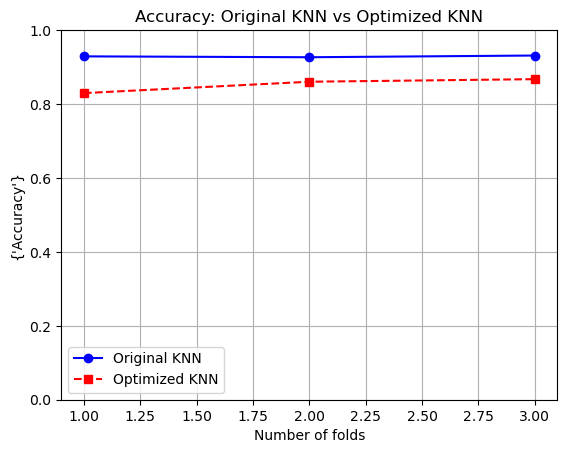

Mean Accuracy Original KNN: 0.9289669742094095
Mean Accuracy Optimized KNN: 0.8524131355338063


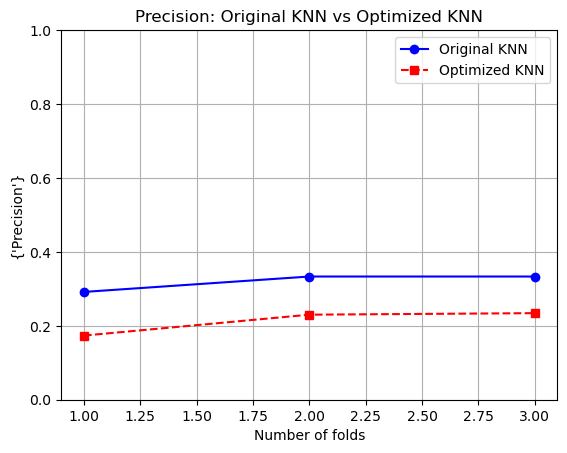

Mean Precision Original KNN: 0.3194444444444444
Mean Precision Optimized KNN: 0.21264461364018886


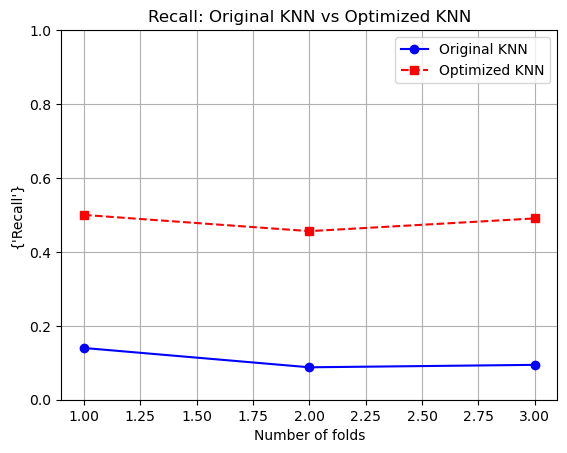

Mean Recall Original KNN: 0.10735297362904117
Mean Recall Optimized KNN: 0.482235462871014


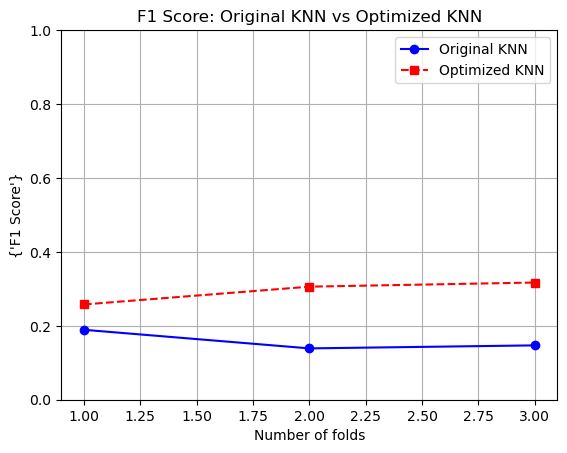

Mean F1 Score Original KNN: 0.15837896720249664
Mean F1 Score Optimized KNN: 0.2935624941452568


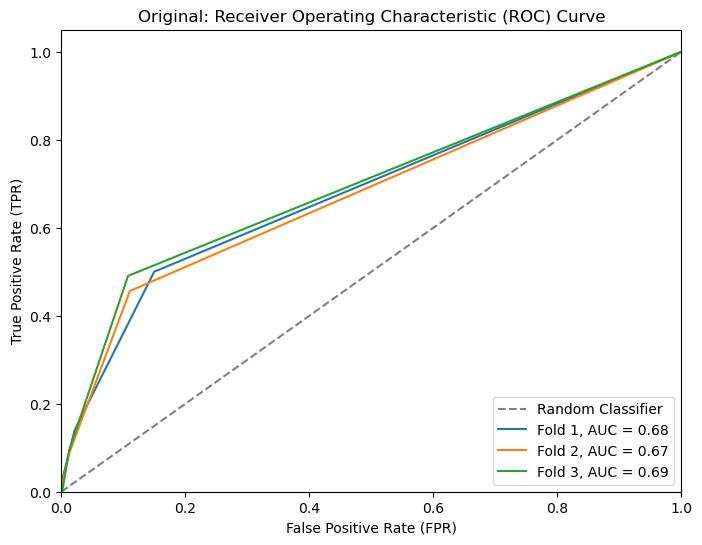

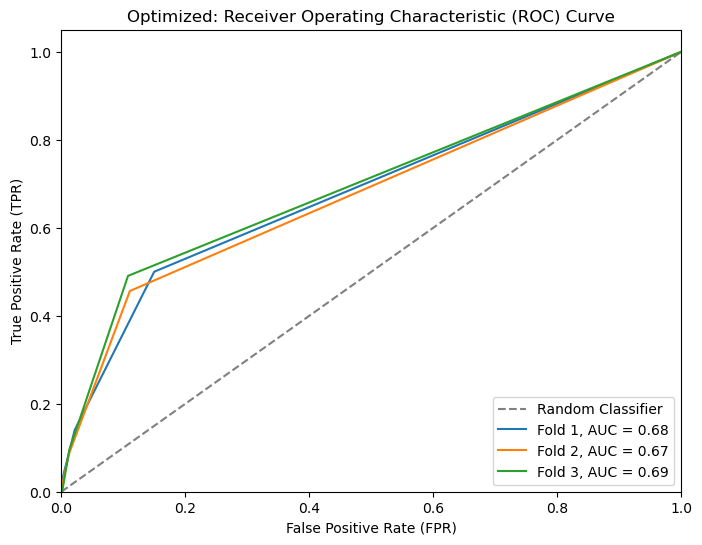

In [265]:
performance_comparison_pipeline(dataframerinos[0])

#### <b> DataSet 2 </b>

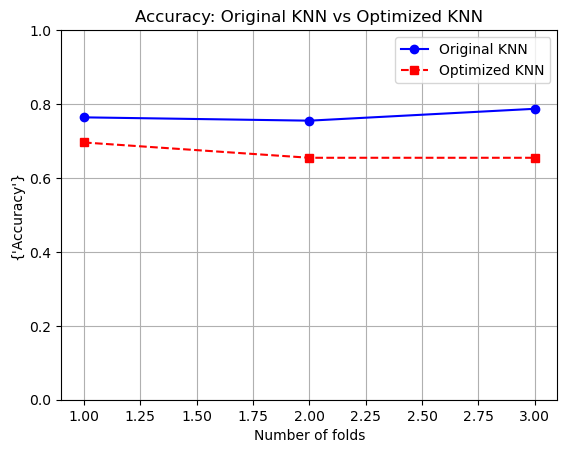

Mean Accuracy Original KNN: 0.768722891566265
Mean Accuracy Optimized KNN: 0.6684123159303882


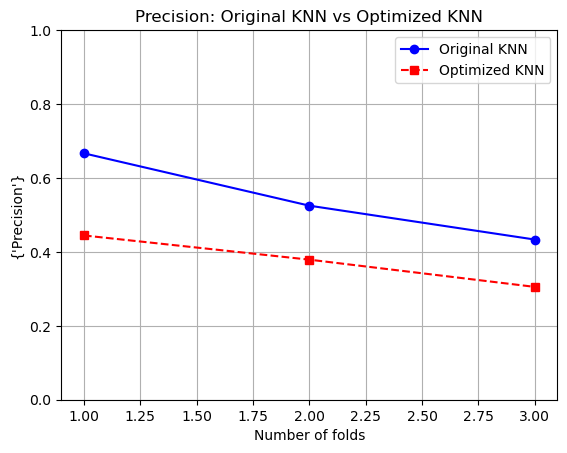

Mean Precision Original KNN: 0.5416666666666666
Mean Precision Optimized KNN: 0.3762183235867447


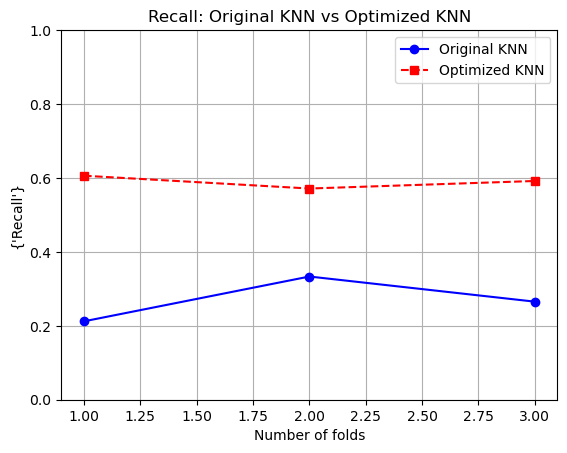

Mean Recall Original KNN: 0.2702535559678417
Mean Recall Optimized KNN: 0.5897753040610184


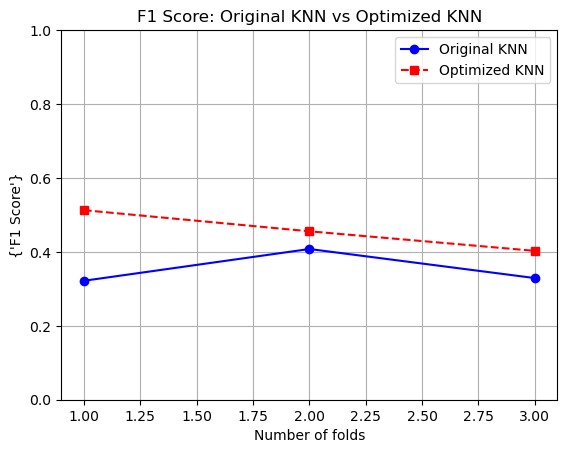

Mean F1 Score Original KNN: 0.35290666493388834
Mean F1 Score Optimized KNN: 0.4570981643766454


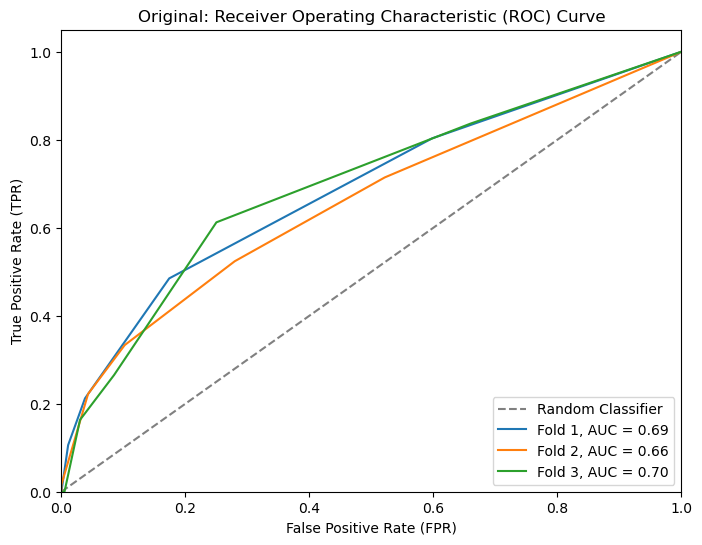

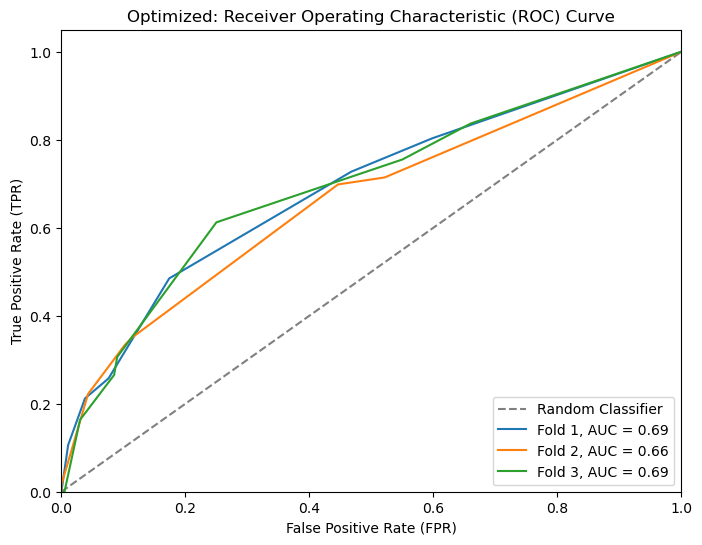

In [264]:
performance_comparison_pipeline(dataframerinos[1])

#### <b> DataSet 3 </b>

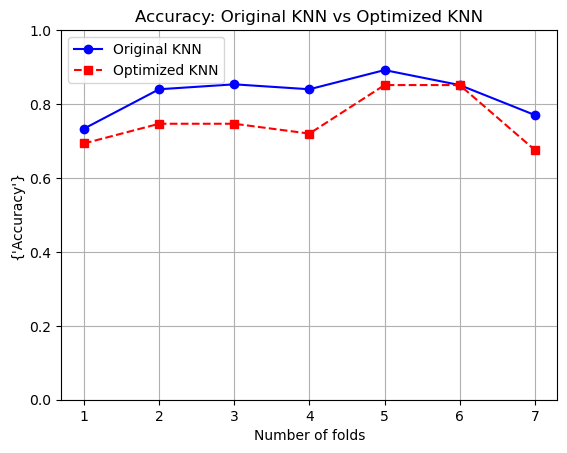

Mean Accuracy Original KNN: 0.8257400257400257
Mean Accuracy Optimized KNN: 0.7550064350064349


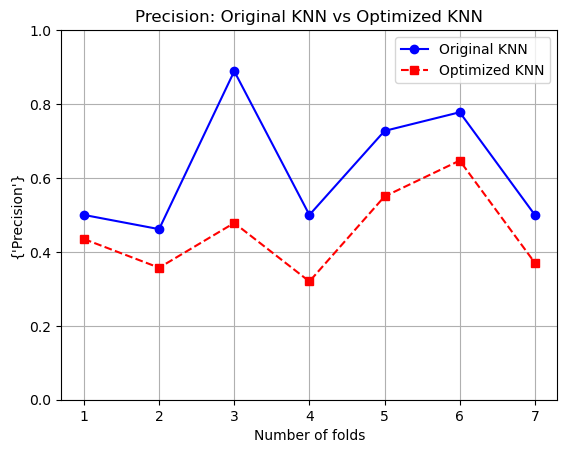

Mean Precision Original KNN: 0.6222111222111222
Mean Precision Optimized KNN: 0.45108793275764414


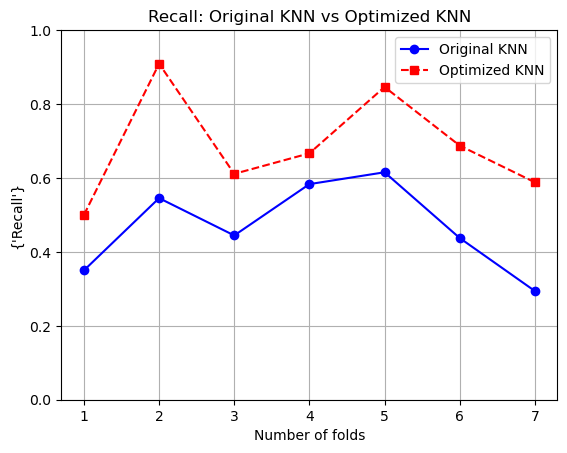

Mean Recall Original KNN: 0.4671763693822517
Mean Recall Optimized KNN: 0.6869654038771686


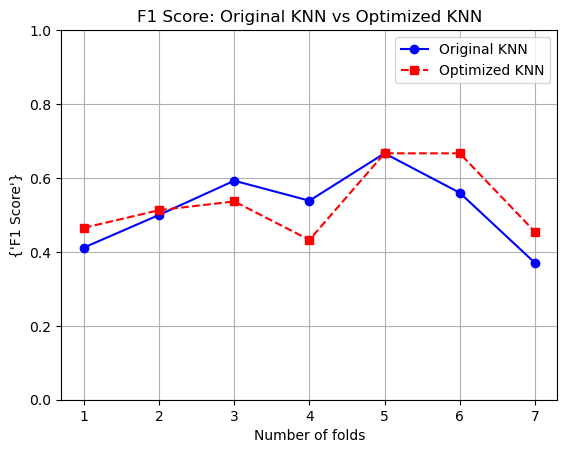

Mean F1 Score Original KNN: 0.5199794105676457
Mean F1 Score Optimized KNN: 0.5335476254364513


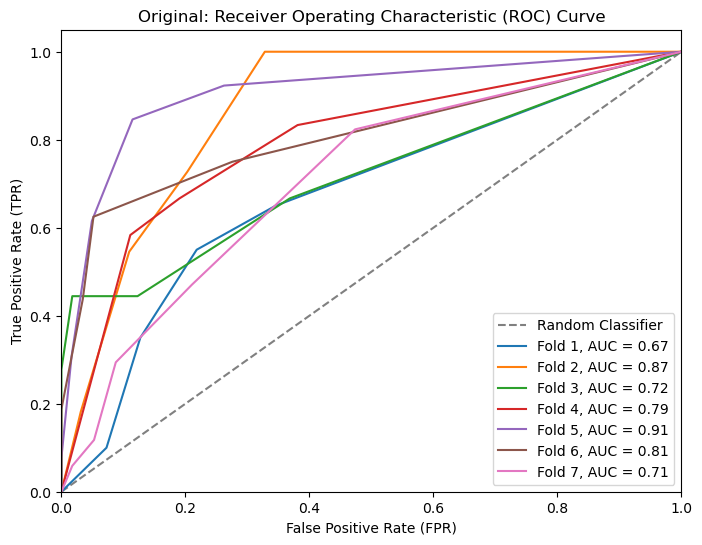

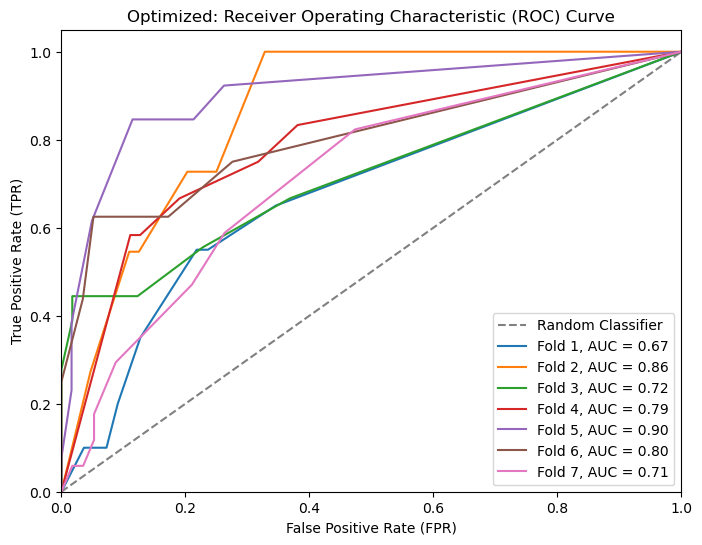

In [261]:
performance_comparison_pipeline(dataframerinos[2])

#### <b> Dataset 4 </b>

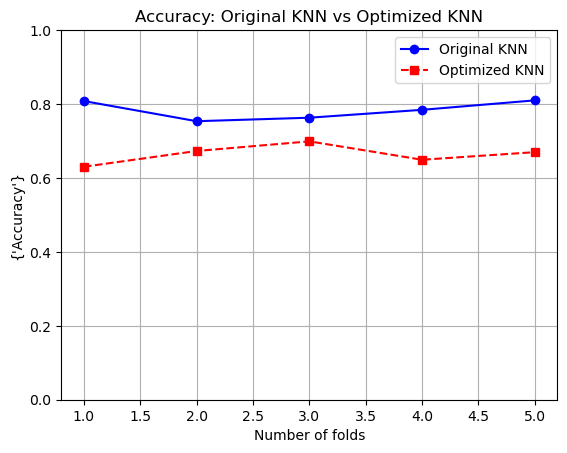

Mean Accuracy Original KNN: 0.7837961972734744
Mean Accuracy Optimized KNN: 0.6642984993977328


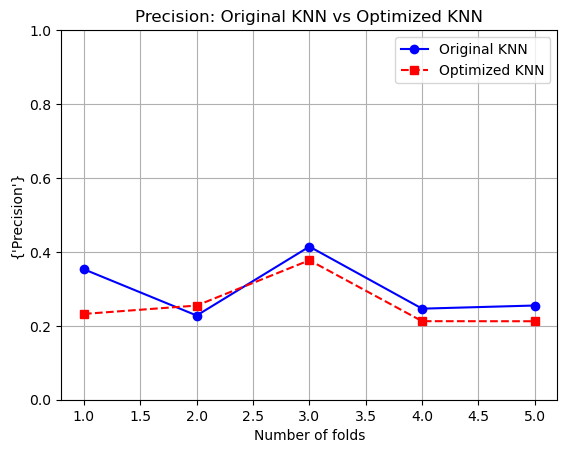

Mean Precision Original KNN: 0.2992707528801284
Mean Precision Optimized KNN: 0.25782143697917537


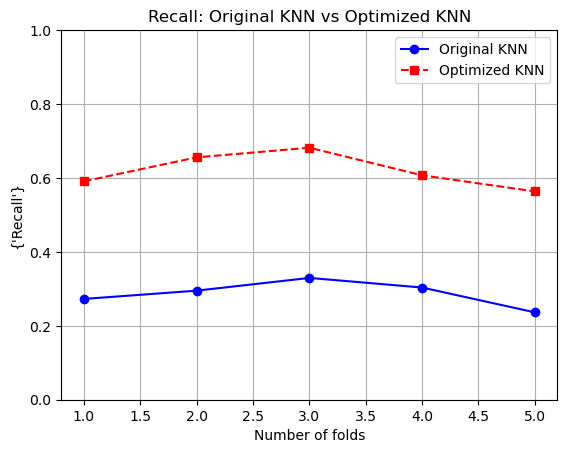

Mean Recall Original KNN: 0.2874579518841814
Mean Recall Optimized KNN: 0.6198488396849052


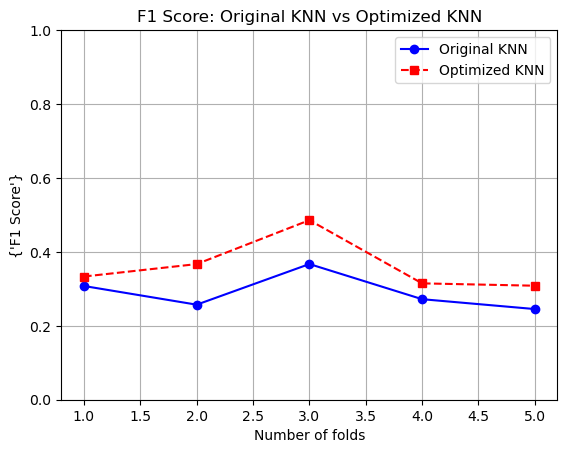

Mean F1 Score Original KNN: 0.2898413582596052
Mean F1 Score Optimized KNN: 0.36188165923386484


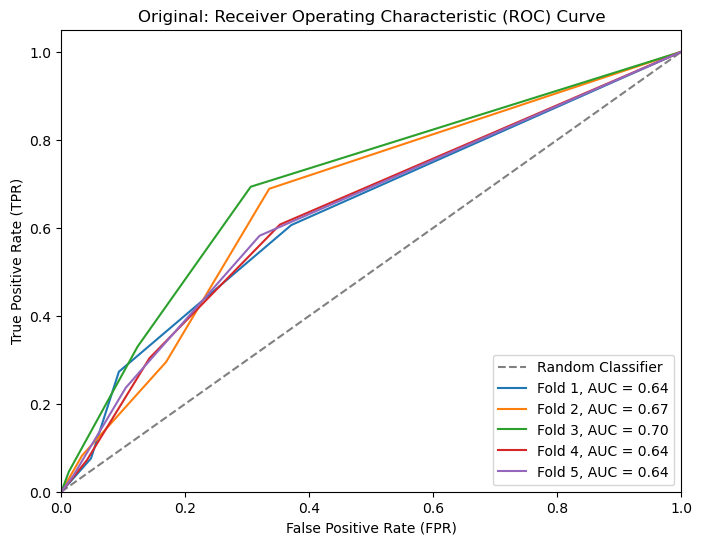

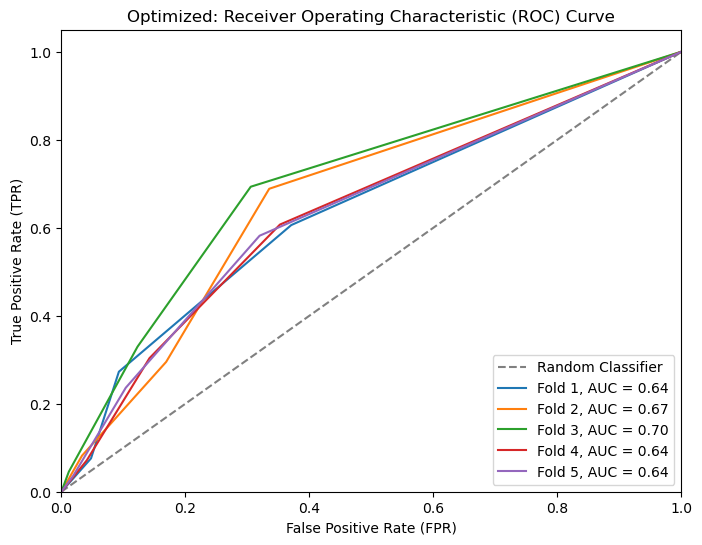

In [263]:
performance_comparison_pipeline(dataframerinos[3])

#### <b> Dataset 5 </b>

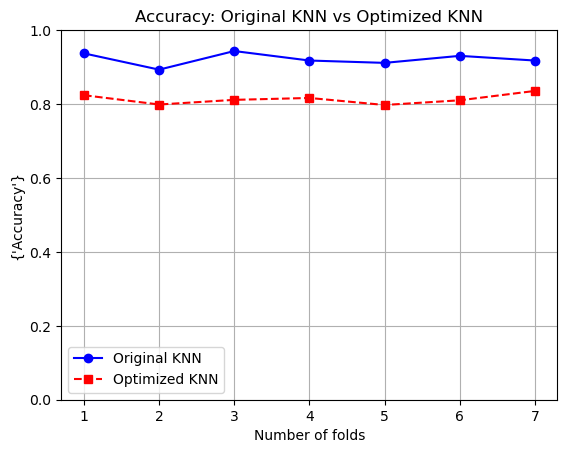

Mean Accuracy Original KNN: 0.9215428707905422
Mean Accuracy Optimized KNN: 0.8133508478624314


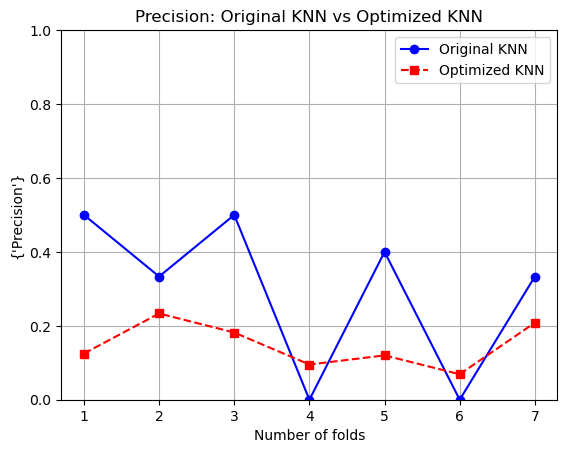

Mean Precision Original KNN: 0.29523809523809524
Mean Precision Optimized KNN: 0.14752692299490328


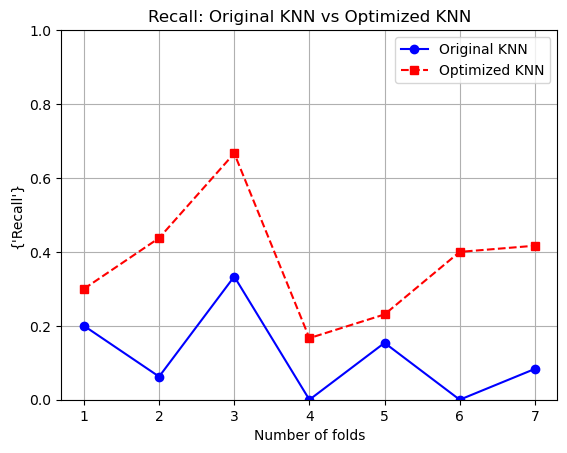

Mean Recall Original KNN: 0.11900183150183151
Mean Recall Optimized KNN: 0.3740384615384616


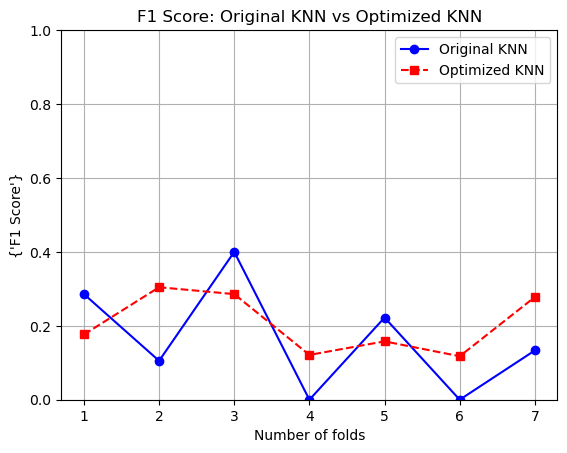

Mean F1 Score Original KNN: 0.16379042845208258
Mean F1 Score Optimized KNN: 0.20586634209886714


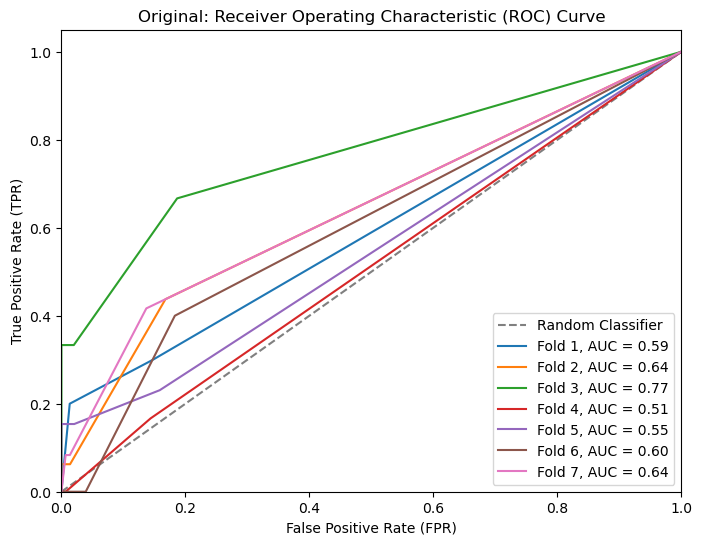

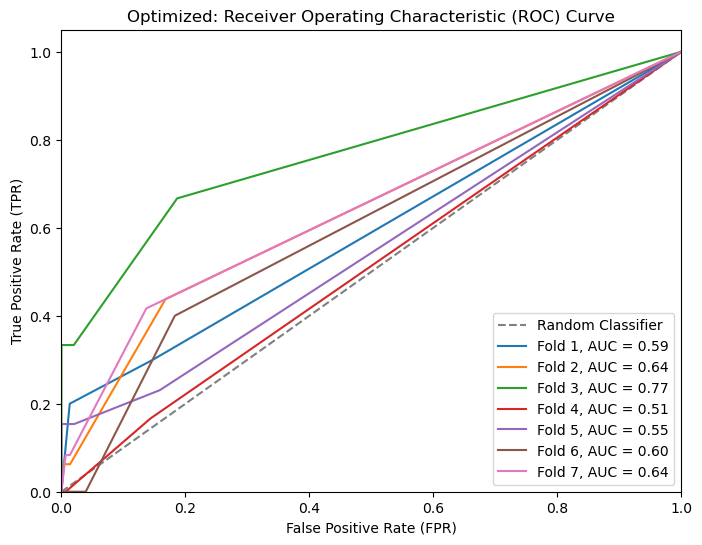

In [262]:
performance_comparison_pipeline(dataframerinos[4])